In [25]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import os
import soundfile as sf
import librosa.display as display

import json
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.externals import joblib

DATA_ROOT = '/scratch/rrs432/openmic/openmic-2018'

if not os.path.exists(DATA_ROOT):
    raise ValueError('Did you forget to set `DATA_ROOT`?')

In [8]:
OPENMIC = np.load(os.path.join(DATA_ROOT, 'openmic-2018.npz'))

In [9]:
print(list(OPENMIC.keys()))
X, Y_true, Y_mask, sample_key = OPENMIC['X'], OPENMIC['Y_true'], OPENMIC['Y_mask'], OPENMIC['sample_key']

['X', 'Y_true', 'Y_mask', 'sample_key']


In [10]:
np.shape(X)

(20000, 10, 128)

In [11]:
np.shape(Y_true)

(20000, 20)

In [12]:
np.shape(Y_mask)

(20000, 20)

In [13]:
np.shape(sample_key)

(20000,)

In [14]:
def aggregate_features(arr):
    mean = np.mean(arr, axis=1)
    std = np.std(arr, axis=1)
    mini = np.min(arr, axis=1)
    maxi = np.max(arr, axis=1)
    return np.concatenate((mean,std,mini,maxi))

In [15]:
rootdir = '/scratch/rrs432/openmic/openmic-2018/audio/'
Z = []

for subdir, dirs, files in os.walk(rootdir):
    for filename in os.listdir(subdir):
        if filename.endswith("0.npy"): 
            os.chdir(subdir)
            arr = np.load(filename)
            
            new_row = aggregate_features(arr)
            
            filename, file_extension = os.path.splitext(filename)
            
            filename = filename + '_d'
            arr = np.load(str(filename)+'.npy')
            
            new_row = np.concatenate((new_row,aggregate_features(arr)))
            
            filename = filename + 'd'
            arr = np.load(str(filename)+'.npy')
            
            new_row = np.concatenate((new_row,aggregate_features(arr)))
            new_row[np.newaxis, :]
            
            if np.size(Z) is 0:
                Z = new_row
            else:
                Z = np.vstack([Z, new_row])

In [16]:
np.shape(Z)

(20000, 240)

In [17]:
split_train = pd.read_csv(os.path.join(DATA_ROOT, 'partitions/split01_train.csv'), 
                          header=None, squeeze=True)
split_test = pd.read_csv(os.path.join(DATA_ROOT, 'partitions/split01_test.csv'), 
                         header=None, squeeze=True)

train_set = set(split_train)
test_set = set(split_test)

In [18]:
# These loops go through all sample keys, and save their row numbers
# to either idx_train or idx_test
#
# This will be useful in the next step for slicing the array data
idx_train, idx_test = [], []

for idx, n in enumerate(sample_key):
    if n in train_set:
        idx_train.append(idx)
    elif n in test_set:
        idx_test.append(idx)
    else:
        # This should never happen, but better safe than sorry.
        raise RuntimeError('Unknown sample key={}! Abort!'.format(sample_key[n]))
        
# Finally, cast the idx_* arrays to numpy structures
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

In [19]:
# Finally, we use the split indices to partition the features, labels, and masks
Z_train = Z[idx_train]
Z_test = Z[idx_test]

Y_true_train = Y_true[idx_train]
Y_true_test = Y_true[idx_test]

Y_mask_train = Y_mask[idx_train]
Y_mask_test = Y_mask[idx_test]

In [20]:
# Print out the sliced shapes as a sanity check
print(Z_train.shape)
print(Z_test.shape)

(14915, 240)
(5085, 240)


In [21]:
with open(os.path.join(DATA_ROOT, 'class-map.json'), 'r') as f:
    class_map = json.load(f)

In [26]:
# This dictionary will include the classifiers for each model
models = dict()

# We'll iterate over all istrument classes, and fit a model for each one
# After training, we'll print a classification report for each instrument
for instrument in class_map:
    
    # Map the instrument name to its column number
    inst_num = class_map[instrument]
        
    # Step 1: sub-sample the data
    
    # First, we need to select down to the data for which we have annotations
    # This is what the mask arrays are for
    train_inst = Y_mask_train[:, inst_num]
    test_inst = Y_mask_test[:, inst_num]
    
    # Here, we're using the Y_mask_train array to slice out only the training examples
    # for which we have annotations for the given class
    Z_train_inst = Z_train[train_inst]
    
    # Step 2: Label slicing
    
    # We slice the labels to the annotated examples
    # We thresold the label likelihoods at 0.5 to get binary labels
    Y_true_train_inst = Y_true_train[train_inst, inst_num] >= 0.5

    
    # Repeat the above slicing and dicing but for the test set
    Z_test_inst = Z_test[test_inst]
    Y_true_test_inst = Y_true_test[test_inst, inst_num] >= 0.5

    # Step 3.
    # Initialize a new classifier
    clf = RandomForestClassifier(max_depth=8, n_estimators=100, random_state=0)
    
    # Step 4.
    clf.fit(Z_train_inst, Y_true_train_inst)

    # Step 5.
    # Finally, we'll evaluate the model on both train and test
    Y_pred_train = clf.predict(Z_train_inst)
    Y_pred_test = clf.predict(Z_test_inst)
    
    print('-' * 52)
    print(instrument)
    print('\tTRAIN')
    print(precision_recall_fscore_support(Y_true_train_inst, Y_pred_train, average='binary'))
    print('\tTEST')
    print(precision_recall_fscore_support(Y_true_test_inst, Y_pred_test, average='binary'))
    
    # Store the classifier in our dictionary
    models[instrument] = clf
    
# Save model to disk
filename = 'finalized_model.sav'
joblib.dump(models, filename)

----------------------------------------------------
guitar
	TRAIN
(0.8030160226201697, 1.0, 0.8907475169890225, None)
	TEST
(0.6551724137931034, 0.9965034965034965, 0.7905686546463245, None)
----------------------------------------------------
voice
	TRAIN
(0.8623024830699775, 1.0, 0.9260606060606061, None)
	TEST
(0.5994623655913979, 0.9955357142857143, 0.7483221476510068, None)
----------------------------------------------------
bass
	TRAIN
(1.0, 0.3686746987951807, 0.5387323943661971, None)
	TEST
(0.0, 0.0, 0.0, None)
----------------------------------------------------
mallet_percussion
	TRAIN
(1.0, 0.735632183908046, 0.847682119205298, None)
	TEST
(0.4, 0.037914691943127965, 0.06926406926406926, None)
----------------------------------------------------
accordion
	TRAIN
(1.0, 0.18449197860962566, 0.3115124153498871, None)
	TEST
(0.0, 0.0, 0.0, None)
----------------------------------------------------
mandolin
	TRAIN
(1.0, 0.44785276073619634, 0.6186440677966102, None)
	TEST
(0.0

['finalized_model.sav']

In [36]:
rootdir = '/scratch/rrs432/openmic/openmic-2018/audio/'
count = 0

for subdir, dirs, files in os.walk(rootdir):
    for filename in os.listdir(subdir):
        if filename.endswith("0.npy"):
            os.chdir(subdir)
            filename, file_extension = os.path.splitext(filename)
            if filename in train_set:
                count = count + 1

print(count)

14915


In [3]:
rootdir = '/scratch/rrs432/openmic/openmic-2018/audio/'

for subdir, dirs, files in os.walk(rootdir):
    for filename in os.listdir(subdir):        
        if filename.endswith(".ogg"): 
            os.chdir(subdir)
            y, sr = sf.read(filename)
            if y.ndim is 2:
                y = y.sum(axis=1)/2
            #mfcc = librosa.feature.mfcc(y=y, sr=sr)
            melspec = librosa.feature.melspectrogram(y=y, sr=sr)

            filename, file_extension = os.path.splitext(filename)
            filename = filename + '_m'
            
            #np.save(filename, mfcc)
            np.save(filename, melspec)

In [11]:
rootdir = '/scratch/rrs432/openmic/openmic-2018/audio/'

for subdir, dirs, files in os.walk(rootdir):
    for filename in os.listdir(subdir):        
        if filename.endswith(".ogg"): 
            os.chdir(subdir)
            y, sr = sf.read(filename)
            if y.ndim is 2:
                y = y.sum(axis=1)/2
            
            mfcc = librosa.feature.mfcc(y=y, sr=sr)
            mfcc_delta = librosa.feature.delta(mfcc)
            mfcc_delta2 = librosa.feature.delta(mfcc,order=2)
            #melspec = librosa.feature.melspectrogram(y=y, sr=sr)

            filename, file_extension = os.path.splitext(filename)
            filename = filename + '_d'
            
            #np.save(filename, mfcc)
            #np.save(filename, melspec)
            np.save(filename,mfcc_delta)
            
            filename = filename + 'd'
            np.save(filename,mfcc_delta2)

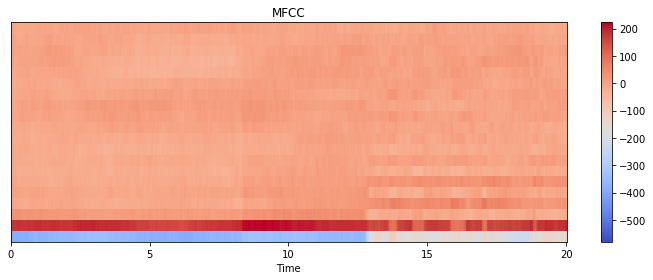

In [22]:
plt.figure(figsize=(10, 4))
display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

In [9]:
arr = np.load('000046_3840.npy')
print(np.shape(arr))
print(arr)

mean,std,mini,maxi = aggregate_features(arr)
# mean = np.mean(arr, axis=1)
# std = np.std(arr, axis=1)
# mini = np.min(arr, axis=1)
# maxi = np.max(arr, axis=1)

new_row = np.concatenate((mean,std,mini,maxi))
new_row[np.newaxis, :]
#print(mean)

# print(np.shape(mean))
# print(mean)
# print(np.shape(std))
# print(std)
# print(np.shape(mini))
# print(mini)
# print(np.shape(maxi))
# print(maxi)

(20, 862)
[[-5.79499281e+02 -5.79499281e+02 -4.86619824e+02 ... -1.53399886e+02
  -1.51686728e+02 -1.42259229e+02]
 [-4.61852778e-14 -4.61852778e-14  1.03727266e+02 ...  1.84985842e+02
   1.84376039e+02  1.94645133e+02]
 [ 4.79616347e-14  4.79616347e-14  4.60065311e+01 ... -1.32698789e+01
  -1.43169107e+01 -1.44128028e+01]
 ...
 [-5.32907052e-14 -5.32907052e-14  1.22837402e+01 ...  1.87056848e+01
   1.64693894e+01  1.97392601e+01]
 [ 1.06581410e-14  1.06581410e-14  6.59537532e+00 ... -3.13749934e+00
  -1.31206048e+00 -1.56535999e+00]
 [ 3.73034936e-14  3.73034936e-14 -3.09255930e+00 ... -1.26108280e+01
  -1.50906661e+01 -1.25886543e+01]]


array([[-2.90512330e+02,  1.74908528e+02,  1.24429184e+01,
         1.47282040e+01,  3.67794825e-01,  9.34473480e+00,
        -1.30901347e+01, -2.17755272e+00, -1.29697584e+01,
        -5.53074164e+00, -7.93147301e-01,  7.75855467e+00,
         8.35095309e+00,  3.99119655e+00,  7.13035760e-01,
        -2.03982480e+00, -6.76253379e-01,  9.66720036e-01,
        -2.66207659e+00, -2.89482704e+00,  9.65691031e+01,
         2.76371061e+01,  2.18817047e+01,  2.63670218e+01,
         1.30329512e+01,  2.15302825e+01,  1.12492343e+01,
         1.09570512e+01,  8.80112003e+00,  9.22966238e+00,
         7.27302084e+00,  8.25254276e+00,  1.07824861e+01,
         9.17187547e+00,  8.01391704e+00,  1.58976397e+01,
         1.73623357e+01,  1.34968151e+01,  7.82871257e+00,
         6.12124947e+00, -5.79499281e+02, -4.61852778e-14,
        -3.34459854e+01, -3.19935158e+01, -3.70455359e+01,
        -2.53813202e+01, -4.43263279e+01, -2.57317098e+01,
        -3.28137249e+01, -2.41859210e+01, -2.73623656e+0